In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint
from boto.s3.connection import S3Connection
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np


%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)

Getting business and review data

In [3]:
import json
import pandas
 
def convertBusiness(x):
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

def convertReviews(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    return {"business_id":ob["business_id"], "stars":ob["stars"], "date":ob["date"]}

def createPandas(func, json_filename):
    return pd.DataFrame([func(line) for line in file(json_filename)])

print "Creating Business Pandas"
pd_business = createPandas(convertBusiness,'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json')
print "Creating Review Pandas"
pd_review = createPandas(convertReviews, 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
print "Completed Creating Pandas"

Creating Business Pandas
Creating Review Pandas
Completed Creating Pandas


Getting business and review data in Vegas

In [4]:
pd_business_lasvegas = pd_business[pd_business["city"] == "Las Vegas"]
pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')

Geographic Clustering of Data

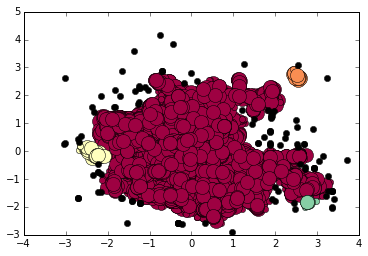

In [5]:
''' DBSCAN : Okayish results '''

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples = db.core_sample_indices_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        markersize = 6
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    
    for index in class_members:
        x = X[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

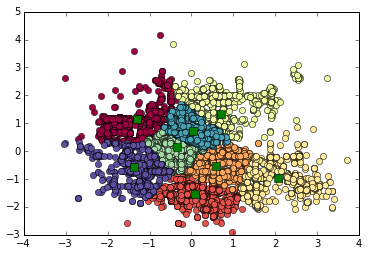

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
''' K Means with results '''

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,kmeans2, vq

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)

k = 8
centroids, labels = kmeans2(X,k)
idx,_ = vq(X,centroids)
colors = pl.cm.Spectral(np.linspace(0, 1, k))
for i in range(k):
    plot(X[idx==i,0],X[idx==i,1], 'o', markerfacecolor=colors[i])
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

# Adding column Cluster indicating cluser number
pd_business_lasvegas['cluster'] = pd.Series(labels, index=pd_business_lasvegas.index)

Label new and old businesses in the cluster

In [13]:
pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')
gb = pd_review_lasvegas.groupby(['business_id'])
gb = gb.agg({'date' : np.min})
gb["new"] = (gb["date"] >= "2011-01-01")
pd_review_lasvegas = pd_review_lasvegas.set_index('business_id')
pd_lasvegas = pd.merge(pd_review_lasvegas, gb, left_index=True, right_index=True, how='inner')
#print list(pd_lasvegas.columns.values)

In [15]:
# Identifying cluster with maximum reviews
#for cluster in range(8):
#    print pd_lasvegas[pd_lasvegas["cluster"] == cluster].shape

pd_lasvegas_cluster0 = pd_lasvegas[pd_lasvegas["cluster"] == 0] 
pd_lasvegas_new = pd_lasvegas_cluster0[pd_lasvegas_cluster0["new"] == True]
pd_lasvegas_old = pd_lasvegas_cluster0[pd_lasvegas_cluster0["new"] == False]

print pd_lasvegas_new.shape, pd_lasvegas_old.shape

(38715, 62)
(55216, 62)
(36681, 62)
(23007, 62)
(34507, 62)
(275796, 62)
(114968, 62)
(38468, 62)
(13663, 62) (25052, 62)


In [28]:
new_business_dict = pd_lasvegas_new.T.to_dict('list')
old_business_dict = pd_lasvegas_old.T.to_dict('list')

/Library/Python/2.7/site-packages/pandas/core/frame.py:797: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [41]:
attrs = [u'attributes_Accepts Credit Cards', u'attributes_Accepts Insurance',
       u'attributes_Ages Allowed', u'attributes_Alcohol',
       u'attributes_Ambience', u'attributes_Attire', u'attributes_BYOB',
       u'attributes_BYOB/Corkage', u'attributes_By Appointment Only',
       u'attributes_Caters', u'attributes_Coat Check',
       u'attributes_Corkage', u'attributes_Delivery',
       u'attributes_Dietary Restrictions', u'attributes_Dogs Allowed',
       u'attributes_Drive-Thru', u'attributes_Good For',
       u'attributes_Good For Dancing', u'attributes_Good For Groups',
       u'attributes_Good For Kids', u'attributes_Good for Kids',
       u'attributes_Hair Types Specialized In', u'attributes_Happy Hour',
       u'attributes_Has TV', u'attributes_Music',
       u'attributes_Noise Level', u'attributes_Open 24 Hours',
       u'attributes_Order at Counter', u'attributes_Outdoor Seating',
       u'attributes_Parking', u'attributes_Payment Types',
       u'attributes_Price Range', u'attributes_Smoking',
       u'attributes_Take-out', u'attributes_Takes Reservations',
       u'attributes_Waiter Service', u'attributes_Wheelchair Accessible',
       u'attributes_Wi-Fi', u'categories', u'city', u'full_address',
       u'hours_Friday', u'hours_Monday', u'hours_Saturday',
       u'hours_Sunday', u'hours_Thursday', u'hours_Tuesday',
       u'hours_Wednesday',u'neighborhoods', u'open']
temp_lasvegas_new = pd_lasvegas_new[attrs]
temp_lasvegas_old = pd_lasvegas_old[attrs]

lasvegas_new_dict =  temp_lasvegas_new.T.to_dict()
lasvegas_old_dict =  temp_lasvegas_old.T.to_dict()

In [59]:
def getVector(old, new):
    res = []
    for attr in attrs:
        if pd.isnull(old[attr]) or pd.isnull(new[attr]):
            continue
        res.append({attr: old[attr] == new[attr]})
    return res
    
for k, new_val in lasvegas_new_dict.iteritems():
    new_business_id = k
    business_vectors = [{k: getVector(old_val, new_val)} for k, old_val in lasvegas_old_dict.iteritems()]

In [108]:
temp = pd_review_lasvegas.loc[[new_business_id]]
before_date = temp[["date"]].min()
print before_date

before_review_lasvegas = pd_review_lasvegas[pd_review_lasvegas["date"] < "2011-01-01"]
before_review_lasvegas = before_review_lasvegas[["date", "stars_y"]]

after_review_lasvegas = pd_review_lasvegas[pd_review_lasvegas["date"] > "2011-01-01"]
after_review_lasvegas = after_review_lasvegas[["date", "stars_y"]]

#print before_review_lasvegas, after_review_lasvegas

Y = []
for idx, business_vector in enumerate(business_vectors):
    business_id = business_vector.keys()
    before_review =  before_review_lasvegas.loc[business_id]
    after_review = after_review_lasvegas.loc[business_id]
    before_created = before_review[["stars_y"]].mean()
    after_created = after_review[["stars_y"]].mean()
    Y.append(np.subtract(after_created , before_created))

date    2014-04-10
dtype: object


KeyError: "None of [[u'vzgSstqNsZZcMgbkgzkZOA']] are in the [index]"